<a href="https://colab.research.google.com/github/lawgorithm/timeseries/blob/main/Simulate_an_OU_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ouparams

In [2]:
import numpy as np
from ouparams import ouparams
import matplotlib.pyplot as plt

In [3]:
def t_vector(T, dt):
    """Creates a vector of time points.

    Args:
        T (float): The end time of the time vector.
        dt (float): The time step size.

    Returns:
        numpy.ndarray: A vector of time points starting at 0 and ending at T with step size dt.
    """
    return np.arange(0, T, dt)

def simulate_ou(mu, theta, sigma, t, dt, x0):
    """Simulates an Ornstein-Uhlenbeck (OU) process.

    Args:
        mu (float): The long-term mean of the process.
        theta (float): The mean reversion rate.
        sigma (float): The volatility of the process.
        t (numpy.ndarray): The time points at which to simulate the process.
        dt (float): The time step size.
        x0 (float): The initial value of the process.

    Returns:
        numpy.ndarray: The simulated OU process values at the specified time points.
    """
    n = len(t)
    x = np.zeros(n)
    x[0] = x0
    dW = np.random.normal(0, np.sqrt(dt), size=n)
    for i in range(1, n):
        x[i] = x[i-1] + theta * (mu - x[i-1]) * dt + sigma * dW[i]
    return x

# OU Process example

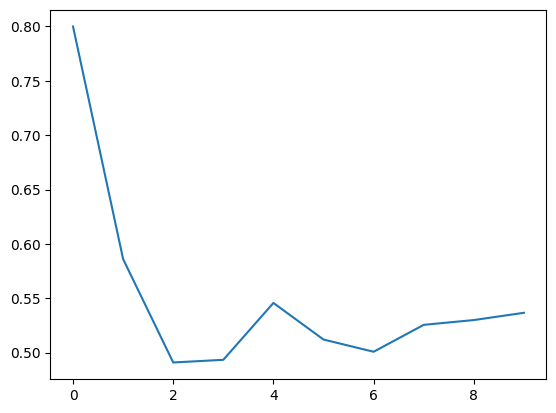

In [4]:
# Sample data (replace with your actual data)
data = np.array([
    0.8,
    0.58606434,
    0.49098481,
    0.49343492,
    0.54575029,
    0.51207641,
    0.50084814,
    0.52559959,
    0.53000366,
    0.53668143])
plt.plot(data)

In [5]:
# Estimate parameters
mu_est, sigma_est, theta_est = ouparams.find(data)

print("mu_est:", mu_est)
print("sigma_est:", sigma_est)
print("theta_est:", theta_est)

mu_est: 0.5171166243459767
sigma_est: 0.038885729337555484
theta_est: 1.5906939803229536


In [6]:
# Parameters

T = 100 # time duration, e.g. 100 days
dt = 0.1 # "mesh size" of the time step. E.g.
x0 = 1.05 * mu_est # Initial value
num_simulations = 1000
t_vec = t_vector(T, dt)

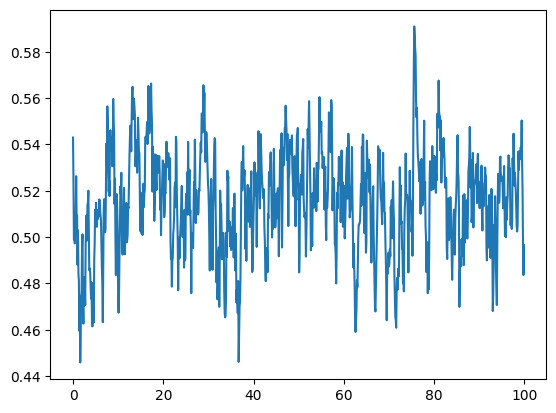

In [7]:
example_OU_draw = simulate_ou(mu_est, theta_est, sigma_est, t_vec, dt, x0)
# Plot forecasts
plt.plot(
    t_vec,
    example_OU_draw,
    label='Example Draw of the OU stochastic process')

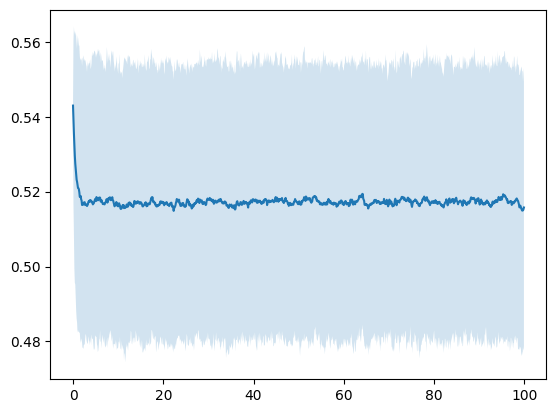

In [8]:
forecasts = np.zeros((num_simulations, len(t_vec)))
for i in range(num_simulations):
    x = simulate_ou(mu_est, theta_est, sigma_est, t_vec, dt, x0)
    forecasts[i, :] = x

# Calculate mean, median, and quantiles of forecasts
# I think the quantiles are basically pointwise CIs using a parametric boostrap
mean_forecast = np.mean(forecasts, axis=0)
lower_quantile = np.quantile(forecasts, 0.05, axis=0)
upper_quantile = np.quantile(forecasts, 0.95, axis=0)

# Plot forecasts
plt.plot(
    t_vec,
    mean_forecast,
    label='Median Forecast')
plt.fill_between(
    t_vec,
    lower_quantile,
    upper_quantile,
    alpha=0.2)
plt.show()

# Geometric OU examples

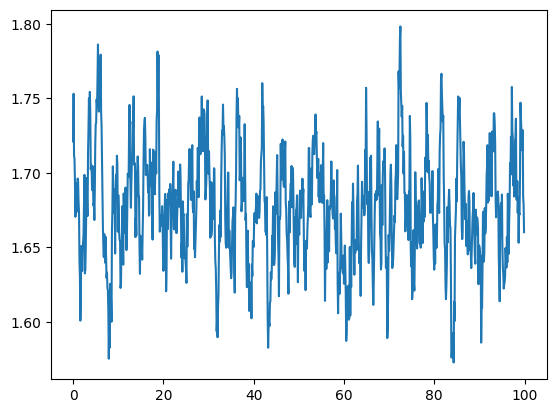

In [9]:
# OU Process example
example_geom_OU_draw = np.exp(simulate_ou(
    mu_est, theta_est, sigma_est, t_vec, dt, x0))
# Plot forecasts
plt.plot(
    t_vec,
    example_geom_OU_draw,
    label='Example Draw of the Geometric OU stochastic process')